In [2]:
# imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/mj/m28wyfp54xbfc1pkqh5_b64r0000gn/T/ipykernel_4938/909018608.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# For matrix_array_20 = 1hour data

In [3]:
matrix_array_20 = np.load('Data/matrix_array_20_normalized.npy')
# answer_array_20 = np.load('Data/answer_array_20.npy')

# List of file names to load
file_names_answer = [f"Data/answer_array_20_{i}.npy" for i in range(11)]

# Load each file and store in a list
loaded_arrays_answer = [np.load(file_name) for file_name in file_names_answer]

# Concatenate all arrays into a single array
answer_array_20 = np.concatenate(loaded_arrays_answer, axis=0)

In [5]:
matrix_array_20.shape, answer_array_20.shape    

((587563, 20, 19), (587563, 3))

In [4]:
from sklearn.model_selection import train_test_split

X = matrix_array_20
y = answer_array_20


X_train, X_temp, y_train, y_temp = train_test_split(X,y, test_size=0.8, random_state=1, stratify=y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1, stratify=y_temp)

In [5]:
# Flatten the X_train data
# This assumes X_train is a list of numpy arrays with a shape of (20, 19)
X_train_flattened = np.array([x.flatten() for x in X_train])
X_test_flattened = np.array([x.flatten() for x in X_test])
# Assuming y_train is a list or array of arrays like [[1, 0, 0], [0, 1, 0], [0, 0, 1], ...]
y_train_transformed = np.array([1 if np.argmax(y) == 0 else (0 if np.argmax(y) == 2 else -1) for y in y_train])
y_test_transformed = np.array([1 if np.argmax(y) == 0 else (0 if np.argmax(y) == 2 else -1) for y in y_test])

### Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier

RFC = RandomForestClassifier(random_state=1, verbose=1, n_jobs=-1)

In [11]:
RFC.fit(X_train_flattened, y_train_transformed)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   47.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished


RandomForestClassifier(n_jobs=-1, random_state=1, verbose=1)

In [12]:
y_pred = RFC.predict(X_test_flattened)


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.6s finished


In [13]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy = accuracy_score(y_test_transformed, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report
report = classification_report(y_test_transformed, y_pred)
print("Classification Report:")
print(report)

Accuracy: 0.686796354445891
Classification Report:
              precision    recall  f1-score   support

          -1       0.66      0.68      0.67     81380
           0       0.72      0.77      0.74     74865
           1       0.68      0.62      0.65     78781

    accuracy                           0.69    235026
   macro avg       0.69      0.69      0.69    235026
weighted avg       0.69      0.69      0.69    235026



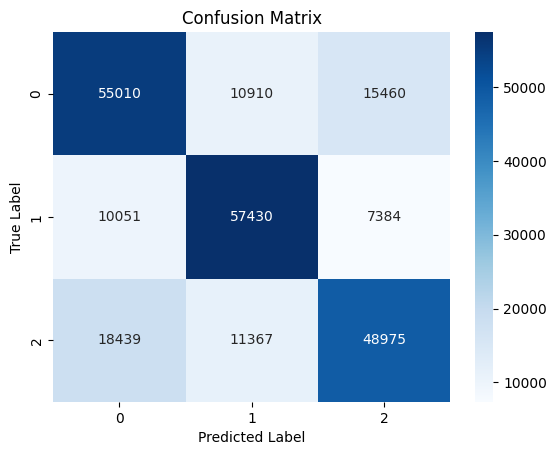

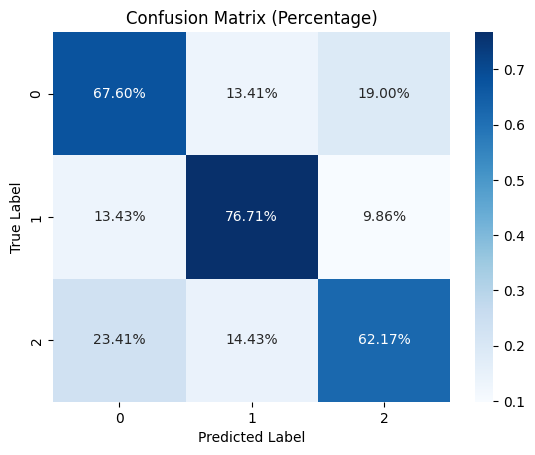

In [14]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test_transformed, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Assuming 'cm' is your confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [10]:
data = pd.read_csv('Data/df_all.csv')
data = data.drop(['Open time', 'Close time', 'Ignore','up_cross','down_cross','minutes','log_minutes','side','plus_6','minus_6','zero_6'], axis=1)
print(data.columns)

# Rename columns
new_columns = []
for i in range(20):  # for each time step
    new_columns.extend([f"{col}_{i}" for col in ['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume','MA5','MA10','MA20','MA30','MA60','MA120','MA240', 'BB0','BB+','BB-' ]])
print(len(new_columns))

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Quote asset volume',
       'Number of trades', 'Taker buy base asset volume',
       'Taker buy quote asset volume'],
      dtype='object')
380


(380,)


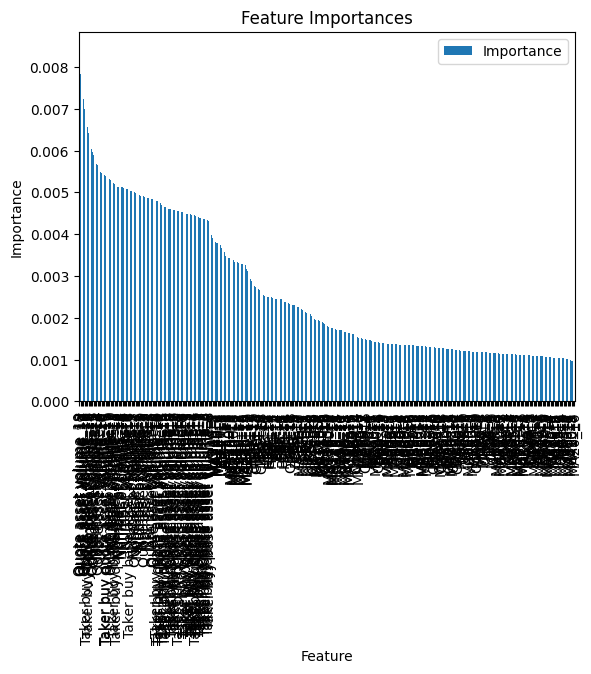

In [16]:
# Get feature importances
importances = RFC.feature_importances_
print(importances.shape)
# Convert to a DataFrame
feature_importance_df = pd.DataFrame({'Feature': new_columns, 'Importance': importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
feature_importance_df.plot(kind='bar', x='Feature', y='Importance')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.show()

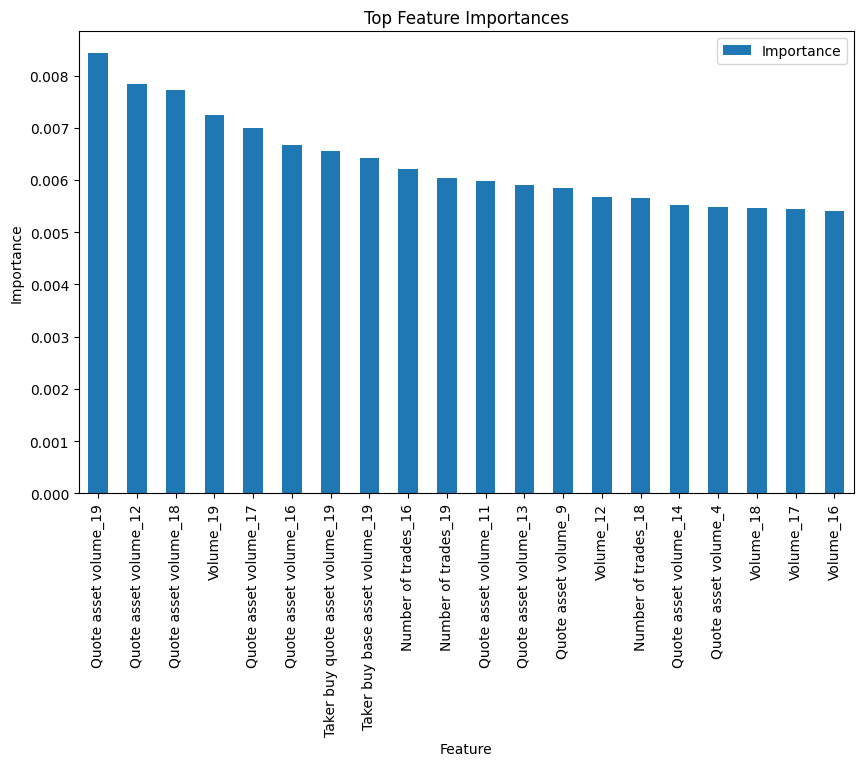

Sorted Feature Importances:
                        Feature  Importance
          Quote asset volume_19    0.008422
          Quote asset volume_12    0.007845
          Quote asset volume_18    0.007717
                      Volume_19    0.007239
          Quote asset volume_17    0.006997
          Quote asset volume_16    0.006662
Taker buy quote asset volume_19    0.006561
 Taker buy base asset volume_19    0.006414
            Number of trades_16    0.006213
            Number of trades_19    0.006035
          Quote asset volume_11    0.005979
          Quote asset volume_13    0.005901
           Quote asset volume_9    0.005856
                      Volume_12    0.005681
            Number of trades_18    0.005653
          Quote asset volume_14    0.005525
           Quote asset volume_4    0.005479
                      Volume_18    0.005456
                      Volume_17    0.005436
                      Volume_16    0.005408
Taker buy quote asset volume_18    0.005406
Take

In [17]:
# Display the top N features in a bar chart
top_n = 20  # You can adjust this number
top_features = feature_importance_df.head(top_n)
top_features.plot(kind='bar', x='Feature', y='Importance', figsize=(10, 6))
plt.title('Top Feature Importances')
plt.ylabel('Importance')
plt.show()

# Print the sorted list of features and their importances
print("Sorted Feature Importances:")
print(feature_importance_df.to_string(index=False))

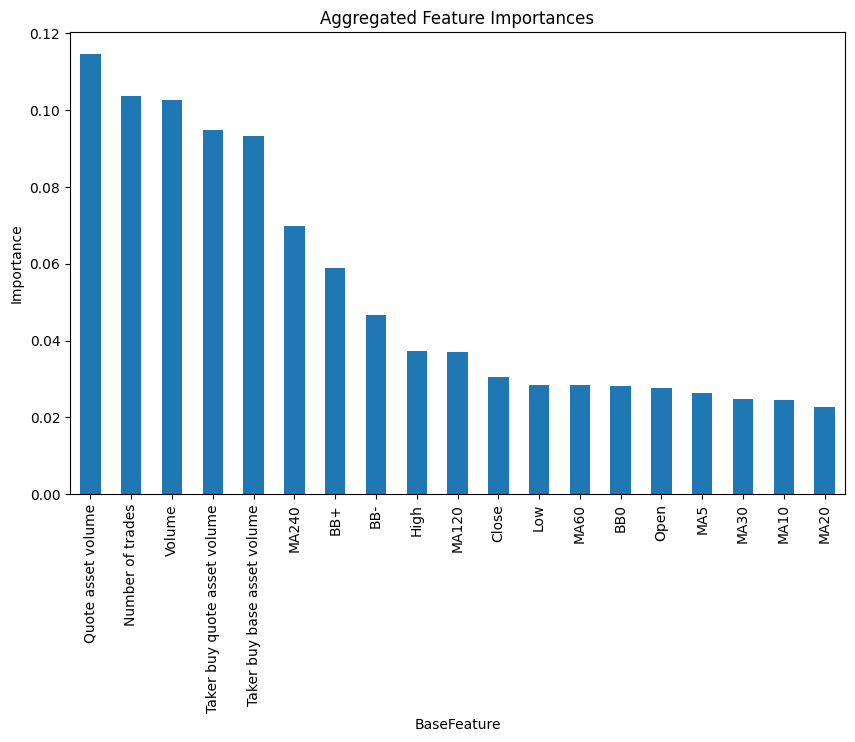

Sorted Aggregated Feature Importances:
BaseFeature
Quote asset volume              0.114568
Number of trades                0.103773
Volume                          0.102724
Taker buy quote asset volume    0.094866
Taker buy base asset volume     0.093248
MA240                           0.069839
BB+                             0.058783
BB-                             0.046641
High                            0.037243
MA120                           0.037066
Close                           0.030577
Low                             0.028339
MA60                            0.028328
BB0                             0.028243
Open                            0.027577
MA5                             0.026233
MA30                            0.024714
MA10                            0.024427
MA20                            0.022808


In [20]:
# Assuming importances and new_columns are defined
feature_importance_df = pd.DataFrame({'Feature': new_columns, 'Importance': importances})

# Split the feature names and aggregate importances
feature_importance_df['BaseFeature'] = feature_importance_df['Feature'].apply(lambda x: x.split('_')[0])
aggregated_importances = feature_importance_df.groupby('BaseFeature')['Importance'].sum()

# Sort by importance
aggregated_importances = aggregated_importances.sort_values(ascending=False)

# Plot aggregated feature importances
aggregated_importances.head(20).plot(kind='bar', figsize=(10, 6))
plt.title('Aggregated Feature Importances')
plt.ylabel('Importance')
plt.show()

# Print the sorted list of aggregated features and their importances
print("Sorted Aggregated Feature Importances:")
print(aggregated_importances.to_string())


In [19]:
import joblib

# Assuming your model is named RFC
joblib.dump(RFC, 'Models/RFC_model.pkl')

['Models/RFC_model.pkl']

### Linear SVC 

#### not that good performance

In [80]:
from sklearn.svm import LinearSVC

# Initialize the LinearSVC model
linear_svc = LinearSVC(random_state=0)

# Fit the model
linear_svc.fit(X_train_flattened, y_train_transformed)

# Make predictions
y_pred = linear_svc.predict(X_test_flattened)



/Users/bae/miniconda3/envs/torch/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/bae/miniconda3/envs/torch/lib/python3.12/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Accuracy: 0.4184047722379652
Classification Report:
              precision    recall  f1-score   support

          -1       0.27      0.00      0.00     81380
           0       0.44      0.69      0.54     74865
           1       0.40      0.59      0.48     78781

    accuracy                           0.42    235026
   macro avg       0.37      0.43      0.34    235026
weighted avg       0.37      0.42      0.33    235026



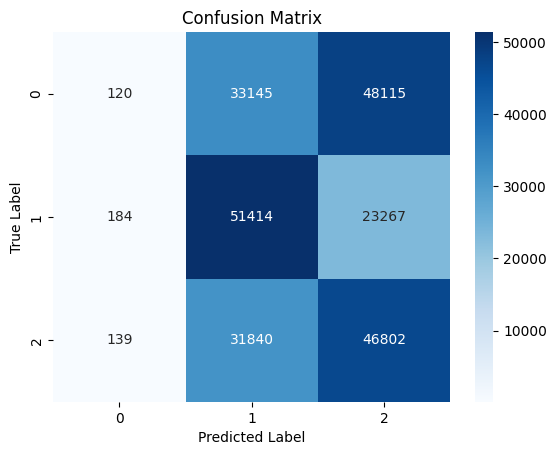

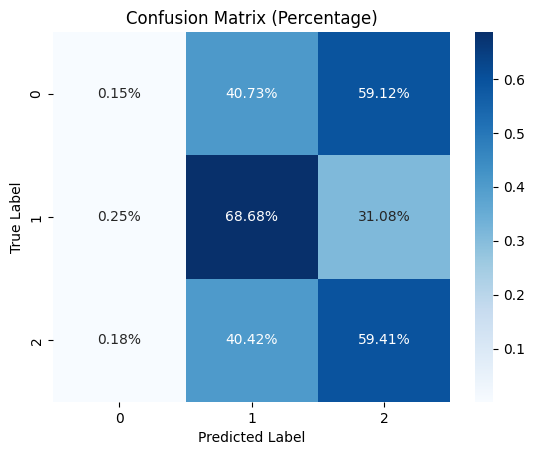

In [82]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test_transformed, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report
report = classification_report(y_test_transformed, y_pred)
print("Classification Report:")
print(report)


# Calculate the confusion matrix
cm = confusion_matrix(y_test_transformed, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Assuming 'cm' is your confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [83]:
# import joblib

# # Assuming your model is named RFC
# joblib.dump(linear_svc, 'Models/Linear_SVC_model.pkl')

['Models/Linear_SVC_model.pkl']

### Nu SVC

#### takes too long time

In [85]:
from sklearn.svm import NuSVC

# Initialize the NuSVC model
# The nu parameter may need to be adjusted based on your dataset
nu_svc = NuSVC(nu=0.5, random_state=0)

# Fit the model
nu_svc.fit(X_train_flattened, y_train_transformed)

# Make predictions
y_pred = nu_svc.predict(X_test_flattened)


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test_transformed, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report
report = classification_report(y_test_transformed, y_pred)
print("Classification Report:")
print(report)


# Calculate the confusion matrix
cm = confusion_matrix(y_test_transformed, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Assuming 'cm' is your confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
import joblib

# Assuming your model is named RFC
joblib.dump(nu_svc, 'Models/Nu_SVC_model.pkl')

### SVC

#### takes too long time

In [21]:
from sklearn.svm import SVC

# Initialize the SVC model
# You can change the kernel to 'linear', 'poly', 'rbf', 'sigmoid', etc.
svc = SVC(kernel='rbf', random_state=0)

# Fit the model
svc.fit(X_train_flattened, y_train_transformed)

# Make predictions
y_pred = svc.predict(X_test_flattened)



In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test_transformed, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report
report = classification_report(y_test_transformed, y_pred)
print("Classification Report:")
print(report)


# Calculate the confusion matrix
cm = confusion_matrix(y_test_transformed, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Assuming 'cm' is your confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Get feature importances
importances = linear_svc.feature_importances_
print(importances.shape)
# Convert to a DataFrame
feature_importance_df = pd.DataFrame({'Feature': new_columns, 'Importance': importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
feature_importance_df.plot(kind='bar', x='Feature', y='Importance')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.show()

# Display the top N features in a bar chart
top_n = 20  # You can adjust this number
top_features = feature_importance_df.head(top_n)
top_features.plot(kind='bar', x='Feature', y='Importance', figsize=(10, 6))
plt.title('Top Feature Importances')
plt.ylabel('Importance')
plt.show()

# Print the sorted list of features and their importances
print("Sorted Feature Importances:")
print(feature_importance_df.to_string(index=False))

In [ ]:
import joblib

# Assuming your model is named RFC
joblib.dump(svc, 'Models/SVC_model.pkl')

### XGBoost

In [7]:
import xgboost as xgb

# Assuming y_train is a list or array of arrays like [[1, 0, 0], [0, 1, 0], [0, 0, 1], ...]
y_train_transformed = np.array([2 if np.argmax(y) == 0 else (1 if np.argmax(y) == 2 else 0) for y in y_train])
y_test_transformed = np.array([2 if np.argmax(y) == 0 else (1 if np.argmax(y) == 2 else 0) for y in y_test])

# Initialize the XGBoost classifier
xgb_model = xgb.XGBClassifier(objective='multi:softprob', random_state=0)  # multi:softprob for multi-class classification

# Fit the model
xgb_model.fit(X_train_flattened, y_train_transformed)

# Make predictions
y_pred = xgb_model.predict(X_test_flattened)

Accuracy: 0.5612825815016211
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.52      0.52     81380
           1       0.63      0.71      0.67     74865
           2       0.53      0.46      0.49     78781

    accuracy                           0.56    235026
   macro avg       0.56      0.56      0.56    235026
weighted avg       0.56      0.56      0.56    235026



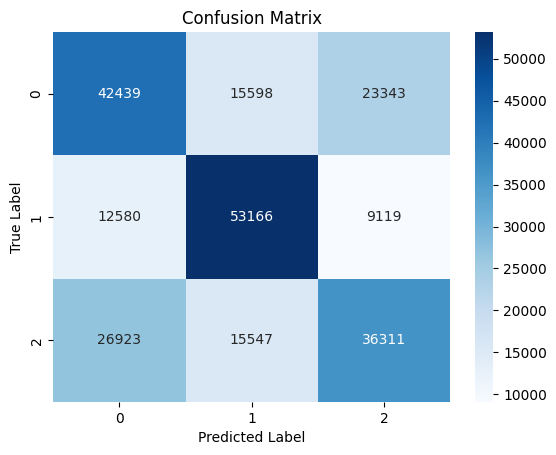

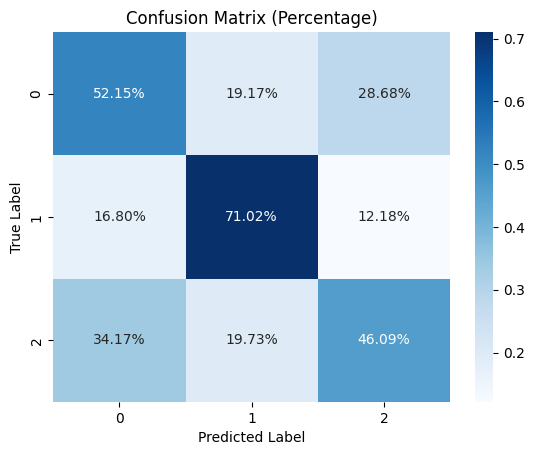

(380,)


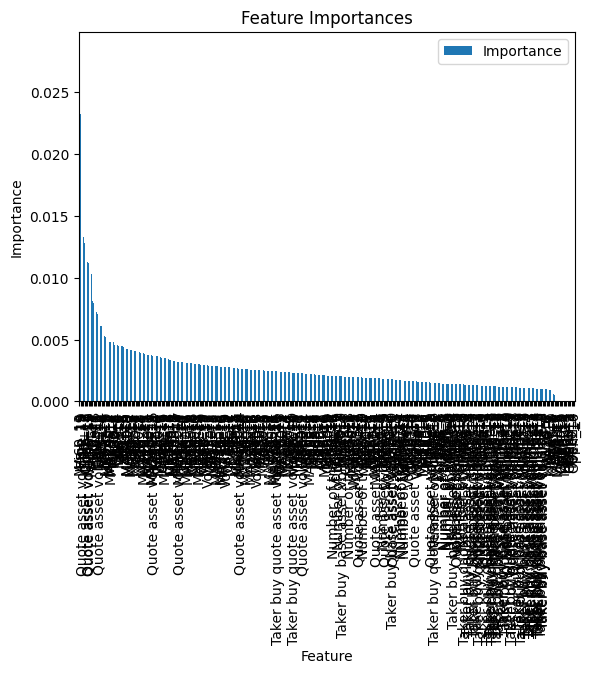

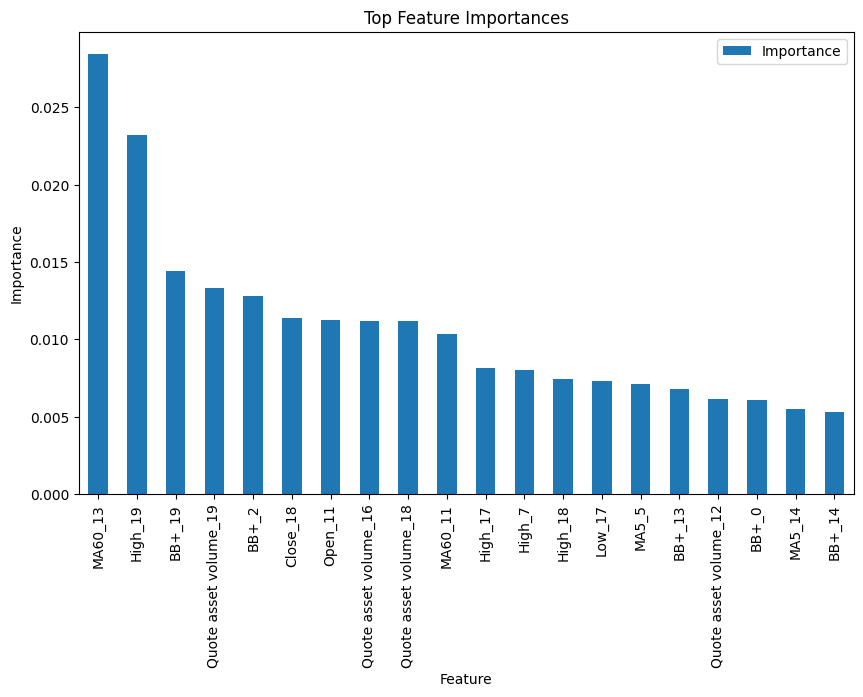

Sorted Feature Importances:
                        Feature  Importance
                        MA60_13    0.028452
                        High_19    0.023207
                         BB+_19    0.014420
          Quote asset volume_19    0.013280
                          BB+_2    0.012825
                       Close_18    0.011387
                        Open_11    0.011255
          Quote asset volume_16    0.011200
          Quote asset volume_18    0.011167
                        MA60_11    0.010319
                        High_17    0.008133
                         High_7    0.007992
                        High_18    0.007397
                         Low_17    0.007271
                          MA5_5    0.007093
                         BB+_13    0.006777
          Quote asset volume_12    0.006128
                          BB+_0    0.006069
                         MA5_14    0.005507
                         BB+_14    0.005262
                        MA60_15    0.005193
    

In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Calculate accuracy
accuracy = accuracy_score(y_test_transformed, y_pred)
print(f"Accuracy: {accuracy}")

# Print classification report
report = classification_report(y_test_transformed, y_pred)
print("Classification Report:")
print(report)


# Calculate the confusion matrix
cm = confusion_matrix(y_test_transformed, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Assuming 'cm' is your confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues')
plt.title('Confusion Matrix (Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Get feature importances
importances = xgb_model.feature_importances_
print(importances.shape)
# Convert to a DataFrame
feature_importance_df = pd.DataFrame({'Feature': new_columns, 'Importance': importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
feature_importance_df.plot(kind='bar', x='Feature', y='Importance')
plt.title('Feature Importances')
plt.ylabel('Importance')
plt.show()

# Display the top N features in a bar chart
top_n = 20  # You can adjust this number
top_features = feature_importance_df.head(top_n)
top_features.plot(kind='bar', x='Feature', y='Importance', figsize=(10, 6))
plt.title('Top Feature Importances')
plt.ylabel('Importance')
plt.show()

# Print the sorted list of features and their importances
print("Sorted Feature Importances:")
print(feature_importance_df.to_string(index=False))

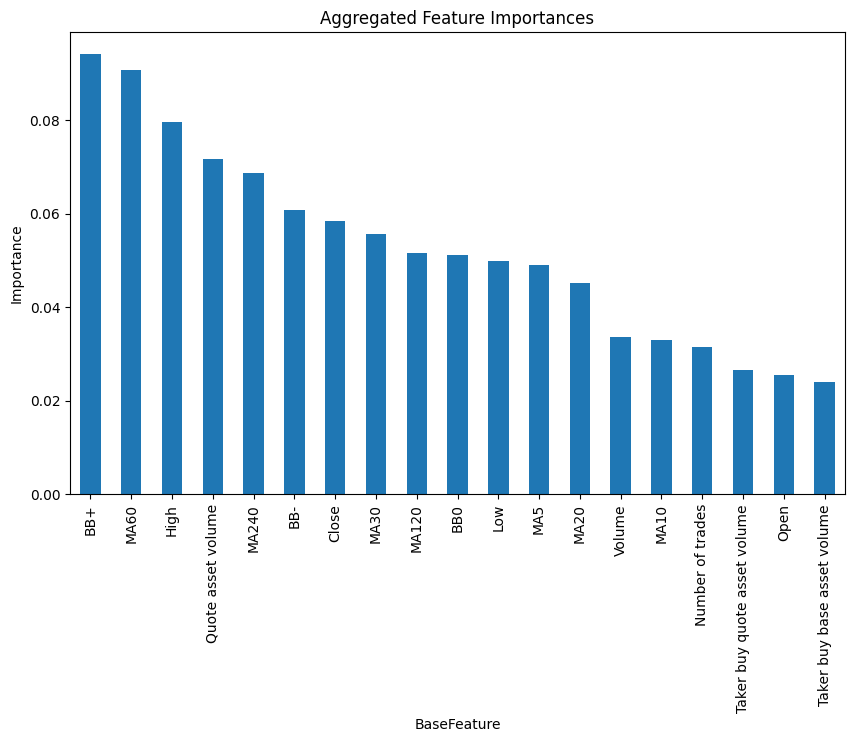

Sorted Aggregated Feature Importances:
BaseFeature
BB+                             0.094079
MA60                            0.090730
High                            0.079480
Quote asset volume              0.071601
MA240                           0.068749
BB-                             0.060818
Close                           0.058388
MA30                            0.055548
MA120                           0.051621
BB0                             0.051156
Low                             0.049783
MA5                             0.048917
MA20                            0.045244
Volume                          0.033637
MA10                            0.032879
Number of trades                0.031374
Taker buy quote asset volume    0.026662
Open                            0.025407
Taker buy base asset volume     0.023926


In [12]:
# Assuming importances and new_columns are defined
feature_importance_df = pd.DataFrame({'Feature': new_columns, 'Importance': importances})

# Split the feature names and aggregate importances
feature_importance_df['BaseFeature'] = feature_importance_df['Feature'].apply(lambda x: x.split('_')[0])
aggregated_importances = feature_importance_df.groupby('BaseFeature')['Importance'].sum()

# Sort by importance
aggregated_importances = aggregated_importances.sort_values(ascending=False)

# Plot aggregated feature importances
aggregated_importances.head(20).plot(kind='bar', figsize=(10, 6))
plt.title('Aggregated Feature Importances')
plt.ylabel('Importance')
plt.show()

# Print the sorted list of aggregated features and their importances
print("Sorted Aggregated Feature Importances:")
print(aggregated_importances.to_string())
